In [139]:
from scipy.io import loadmat
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2 


%matplotlib inline

In [204]:
mat = loadmat('data/example1kinect.mat')

In [205]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Apr 26 16:26:46 2017',
 '__version__': '1.0',
 '__globals__': [],
 'amplitudes1': array([[    0,  1711,  2618, ..., 11774, 17148,     0],
        [    0,  3487,  3862, ...,  6204,  6588,     0],
        [    0,  2883,  1739, ...,  6702,  7729,     0],
        ...,
        [    0,  9210,  7708, ...,  4909,  4566,     0],
        [    0, 17712, 13374, ...,  9831,  7632,     0],
        [    0, 33642, 16712, ...,  6590,  7424,     0]], dtype=uint16),
 'distances1': array([[0.        , 0.        , 0.        , ..., 2.08750653, 9.91966915,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 2.21158051, 0.        ,
         0.        ],
        ...,
        [0.        , 0.81849653, 0.8396064 , ..., 0.86473584, 0.88194507,
         0.        ],
        [0.        , 0.87757653, 0.8493191 , ..., 0.84469038, 0.

In [206]:
print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'amplitudes1', 'distances1', 'cloud1'])


In [207]:
A = mat['amplitudes1']  
D = mat['distances1'] 
PC = mat['cloud1']    

In [208]:
A.shape

(424, 512)

In [209]:
D.shape

(424, 512)

In [210]:
PC.shape

(424, 512, 3)

In [211]:
plt.imshow(A, norm='log', cmap='gray')

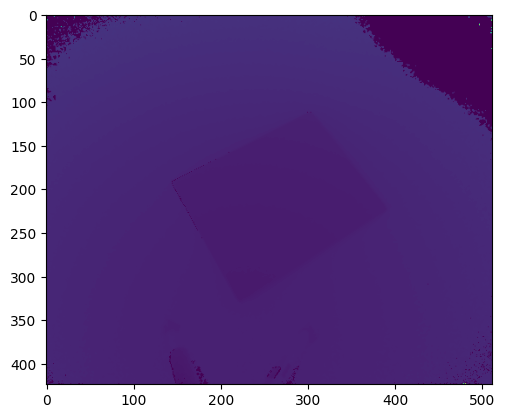

In [194]:
plt.imshow(D, norm='linear')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-5.033220291137695..7.991999626159668].


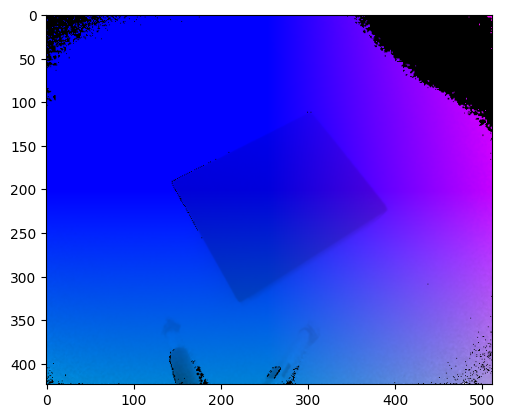

In [195]:
plt.imshow(PC)

In [196]:
x = PC[:, :, 0]
y = PC[:, :, 1]
z = PC[:, :, 2]

In [197]:
x.shape

(424, 512)

In [198]:
x_flat = x.ravel() 
y_flat = y.ravel()
z_flat = z.ravel()

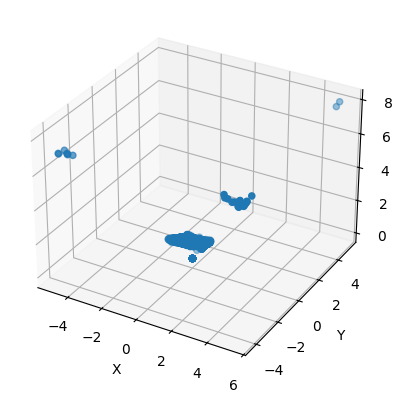

In [199]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x_flat, ys=y_flat, zs=z_flat)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [200]:
subsample_percentage = 1

In [212]:
n = len(x_flat)
subsample_size = int(n * (subsample_percentage / 100))
indices = np.random.choice(n, subsample_size, replace=False)

In [213]:
x_sub = x_flat[indices]
y_sub = y_flat[indices]
z_sub = z_flat[indices]

In [214]:
%matplotlib qt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(xs=x_sub, ys=y_sub, zs=z_sub)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [215]:
subsample_size = 3
point_cloud = PC
height, width, _ =point_cloud.shape
row_indices = np.random.choice(height, subsample_size, replace=False)
col_indices = np.random.choice(width, subsample_size, replace=False)
points_sub = point_cloud[row_indices, col_indices, :]

In [216]:
points_sub

array([[ 0.26094916,  0.35697523,  0.648     ],
       [-0.12914354,  0.08768065,  0.65000004],
       [ 0.05318132,  0.00668588,  0.65700006]])

https://kitchingroup.cheme.cmu.edu/blog/2015/01/18/Equation-of-a-plane-through-three-points/

In [217]:
a = points_sub[2] - points_sub[0]

In [218]:
b = points_sub[2] - points_sub[1]

In [219]:
normal_vector = np.cross(a, b)
normal_vector = normal_vector / np.linalg.norm(normal_vector)
a, b, c = normal_vector

In [220]:
d = np.dot(normal_vector, points_sub[0])

In [221]:
 print('The equation is {0}x + {1}y + {2}z = {3}'.format(a, b, c, d))

The equation is -0.021332534683126313x + 0.03832151119030709y + 0.9990377293896786z = 0.6554895736239646


In [222]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(-2, 14, 5)
y = np.linspace(-2, 14, 5)
X, Y = np.meshgrid(x, y)

Z = (d - a * X - b * Y) / c


# plot the mesh. Each array is 2D, so we flatten them to 1D arrays
ax.plot(X.flatten(),
        Y.flatten(),
        Z.flatten(), 'bo ')

ax.plot(*zip(points_sub[0], points_sub[1], points_sub[2]), color='r', linestyle=' ', marker='o')

ax.view_init(0, 22)
plt.tight_layout()
plt.show()

In [223]:
def dist(x, y, z, a, b, c, d):
    nominator = abs(a*x + b*y + c*z -d)
    denominator = math.sqrt(a**2 + b**2 + c**2)
    return nominator/denominator

In [224]:
def ransac_plane(point_cloud, threshold, max_iter):
    best_score = 0
    best_inliers = []
    for _ in range(max_iter):
        cnt = 0
        subsample_size = 3
        height, width, _ = point_cloud.shape
        row_indices = np.random.choice(height, subsample_size, replace=False)
        col_indices = np.random.choice(width, subsample_size, replace=False)
        points_sub = point_cloud[row_indices, col_indices, :]
        a = points_sub[2] - points_sub[0]
        b = points_sub[2] - points_sub[1]
        normal_vector = np.cross(a, b)
        normal_vector = normal_vector / np.linalg.norm(normal_vector)
        a, b, c = normal_vector
        d = np.dot(normal_vector, points_sub[0])
        inliers = []
        for row in range(height):
            for column in range(width):
                x, y, z =  point_cloud[row, column, :]
                if x == 0 and y == 0 and z == 0:
                    pass
                else:
                    cnt += 1
                    result = dist(x, y, z, a, b, c, d)
                    if abs(result) < threshold:
                        inliers.append((row, column))
        print("count: ", cnt)
        print("all: ", len(inliers))
        score = len(inliers) / cnt *100
        print(f"percentage of inliers are {score}.")
        if score > best_score:
            best_score = score
            best_inliers = inliers
    print("best score: ", best_score)
    return best_inliers

In [225]:
best_inliers = ransac_plane(PC, 0.1, 20)

count:  202007
all:  101963
percentage of inliers are 50.47498354017434.
count:  202007
all:  83901
percentage of inliers are 41.53370922789804.
count:  202007
all:  44930
percentage of inliers are 22.241803501858847.
count:  202007
all:  113002
percentage of inliers are 55.939645655843606.
count:  202007
all:  74574
percentage of inliers are 36.91654249605212.
count:  202007
all:  40705
percentage of inliers are 20.15029182157054.
count:  202007
all:  30305
percentage of inliers are 15.001955377783938.
count:  202007
all:  94493
percentage of inliers are 46.77709188295455.
count:  202007
all:  119432
percentage of inliers are 59.12270366868475.
count:  202007
all:  98604
percentage of inliers are 48.81216987530135.
count:  202007
all:  44926
percentage of inliers are 22.23982337245739.
count:  202007
all:  72883
percentage of inliers are 36.07944279158643.
count:  202007
all:  57775
percentage of inliers are 28.60049404228566.
count:  202007
all:  14560
percentage of inliers are 7.207

In [226]:
inlier_points = np.array([PC[row, col, :] for row, col in best_inliers])

In [227]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_plane(point_cloud, best_inliers, a, b, c, d):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Extract the x, y, z coordinates of the point cloud
    height, width, _ = point_cloud.shape
    x_vals = point_cloud[:, :, 0].flatten()
    y_vals = point_cloud[:, :, 1].flatten()
    z_vals = point_cloud[:, :, 2].flatten()

    # Subsample 1% of the total points
    num_points = len(x_vals)
    subsample_size = int(0.1 * num_points)  # 1% of total points
    subsample_indices = np.random.choice(num_points, subsample_size, replace=False)

    x_subsampled = x_vals[subsample_indices]
    y_subsampled = y_vals[subsample_indices]
    z_subsampled = z_vals[subsample_indices]

    # Scatter plot for the subsampled point cloud
    ax.scatter(x_subsampled, y_subsampled, z_subsampled, c='gray', alpha=0.2, s=1, label='Point Cloud')

    # Highlight inliers
    if best_inliers:
        inlier_points = np.array([point_cloud[row, col, :] for row, col in best_inliers])
        ax.scatter(inlier_points[:, 0], inlier_points[:, 1], inlier_points[:, 2], c='r', s=5, label='Plane Inliers')

    # Define a grid to plot the plane
    x_plane, y_plane = np.meshgrid(np.linspace(min(x_subsampled), max(x_subsampled), 10),
                                   np.linspace(min(y_subsampled), max(y_subsampled), 10))
    z_plane = (d - a * x_plane - b * y_plane) / c

    # Plot the plane
    ax.plot_surface(x_plane, y_plane, z_plane, color='blue', alpha=0.3)

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.legend()
    plt.show()


In [228]:
visualize_plane(PC, best_inliers, a, b, c, d)

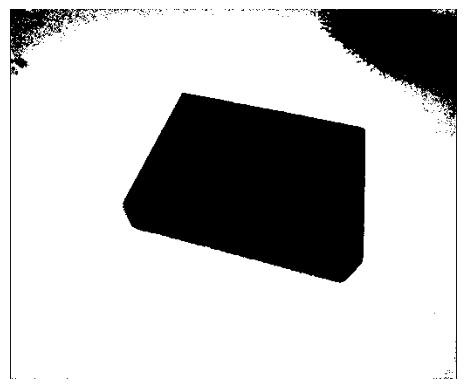

In [229]:
def visualize_2d_floor_mask(point_cloud, best_inliers):
    # Get the dimensions of the point cloud (height and width)
    height, width, _ = point_cloud.shape

    # Create a mask initialized to zeros
    floor_mask = np.zeros((height, width), dtype=np.uint8)

    # Set the inliers in the mask to 1
    for row, col in best_inliers:
        floor_mask[row, col] = 1

    # Visualize the mask using imshow
    plt.imshow(floor_mask, cmap='gray')
    plt.axis('off')
    plt.savefig('floor_mask.png', bbox_inches='tight', pad_inches=0)
    plt.show()

%matplotlib inline
# Call this after running RANSAC to visualize the floor mask
visualize_2d_floor_mask(point_cloud, best_inliers)

In [230]:
img = cv2.imread('floor_mask.png', cv2.IMREAD_GRAYSCALE)
kernel = np.ones((5,5),np.uint8)

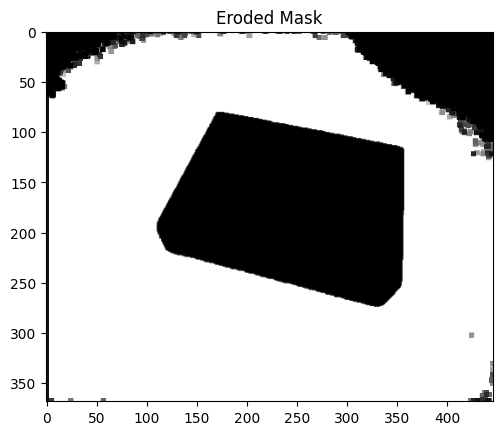

In [231]:
eroded_img = cv2.erode(img, kernel, iterations=1)

# Visualize the eroded image
plt.imshow(eroded_img, cmap='gray')
plt.title('Eroded Mask')
plt.show()

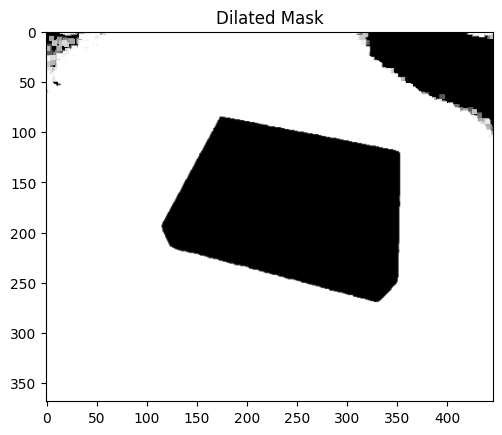

In [232]:
dilated_img = cv2.dilate(img, kernel, iterations=1)

# Visualize the eroded image
plt.imshow(dilated_img, cmap='gray')
plt.title('Dilated Mask')
plt.show()

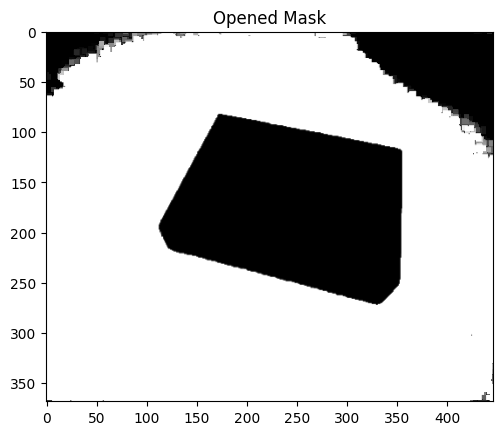

In [233]:
opened_img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

# Visualize the eroded image
plt.imshow(opened_img, cmap='gray')
plt.title('Opened Mask')
plt.show()

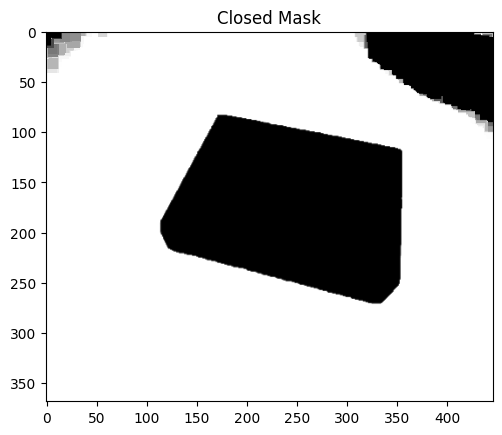

In [234]:
closed_img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=2)

# Visualize the eroded image
plt.imshow(closed_img, cmap='gray')
plt.title('Closed Mask')
plt.show()

In [164]:
inlier_coords = np.array(best_inliers)


In [165]:
inlier_coords

array([[  0,  75],
       [  0,  83],
       [  0,  84],
       ...,
       [423, 507],
       [423, 508],
       [423, 509]])

In [166]:
PC.shape

(424, 512, 3)

In [167]:
# Zero out the inliers in the point cloud
for coord in inlier_coords:
    PC[coord[0], coord[1]] = [0, 0, 0]

In [170]:
box_inliers = ransac_plane(PC, 0.4, 100)

C:\Users\Mahdi\AppData\Local\Temp\ipykernel_134132\3794829818.py:14: RuntimeWarning: invalid value encountered in divide
  normal_vector = normal_vector / np.linalg.norm(normal_vector)


count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  1718
percentage of inliers are 6.331773117605867.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percentage of inliers are 0.0.
count:  27133
all:  0
percent

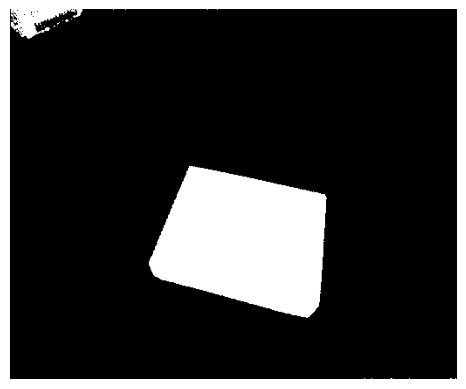

In [235]:
visualize_2d_floor_mask(PC, box_inliers)

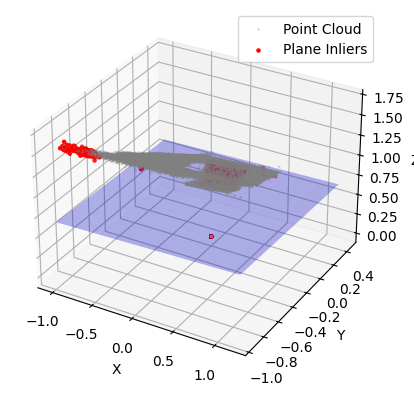

In [236]:
visualize_plane(PC,box_inliers, a, b, c, d)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0650511980056763..1.8000001907348633].


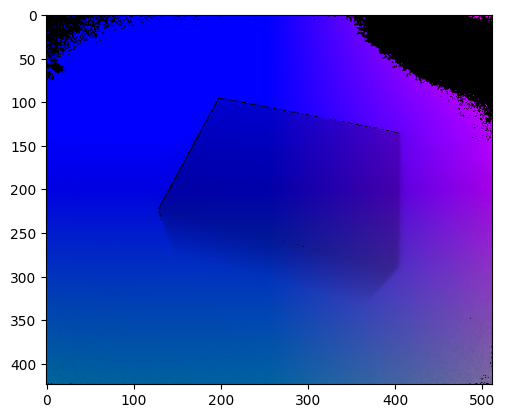

In [237]:
plt.imshow(PC)